In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import json
import joblib
import os

from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Ensure the output directory exists
os.makedirs('figures', exist_ok=True)

In [2]:

# Load model and data
model = joblib.load("trained_amoc_model.pkl")
data = np.load("amoc_ml_input_output.npz")
print(data.files)
# Load correct keys
X_train = data["X_train_bal"]
y_train = data["y_train_bal"]
X_test = data["X_test_pca"]
y_test = data["y_test"]
time = pd.to_datetime(data["time"])

print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"Model expects {model.n_features_in_} features.")


['X_train_bal', 'y_train_bal', 'X_test_pca', 'y_test', 'sst_shape', 'valid_mask_combined', 'time']
X_train shape: (438, 30), X_test shape: (111, 30)
Model expects 30 features.


In [3]:
# Predict using test set
y_pred = model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Ensure output directory exists
os.makedirs("figures", exist_ok=True)

# Plot heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Strong', 'Weak'],
            yticklabels=['Strong', 'Weak'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()

plt.savefig("figures/confusion_matrix.png", dpi=300)
#plt.close()

plt.show()


In [4]:

# Get predicted probabilities for the positive class (class 1 = "Weak")
y_prob = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color="darkorange")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()

plt.savefig("figures/roc_curve.png", dpi=300)
#plt.close()

plt.show()


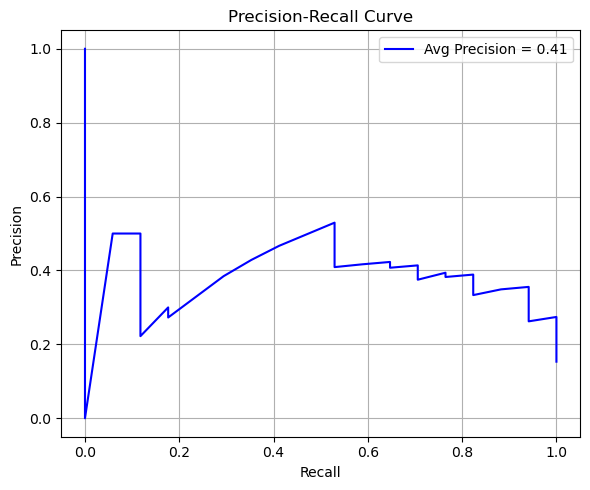

In [5]:

# Get predicted probabilities for the positive class (class 1 = "Weak")
y_prob = model.predict_proba(X_test)[:, 1]

# Compute Precision-Recall curve and average precision score
precision, recall, _ = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)

# Plot Precision-Recall Curve
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, color='blue', label=f"Avg Precision = {avg_precision:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
# Load data and model
model = joblib.load("trained_amoc_model.pkl")
data = np.load("amoc_ml_input_output.npz")

# Extract relevant variables
X_test = data['X_test_pca']
y_test = data['y_test']
time = data['time']

# Predict probabilities and classes
y_prob = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# Match time length to test data
time_test = time[-len(y_test):]  # assumes time corresponds to the full dataset; adjust if needed

# Create DataFrame for plotting
df = pd.DataFrame({
    'time': time_test,
    'y_true': y_test,
    'y_pred': y_pred,
    'y_prob': y_prob
})

# Plot
plt.figure(figsize=(12, 4))
plt.plot(df['time'], df['y_prob'], label='Predicted Probability (Weak AMOC)', color='blue')
plt.scatter(df['time'], df['y_true'], color='red', s=10, label='True Class')
plt.xlabel('Time')
plt.ylabel('Probability / Class')
plt.title('AMOC Weakening Probability Over Time')
plt.legend()
plt.tight_layout()

plt.savefig("figures/amoc_weakening_probability_over_time.png", dpi=300)
#plt.close()

plt.show()


In [7]:
# Load model and importances
model = joblib.load("trained_amoc_model.pkl")
importances = model.feature_importances_

# Define PCA-reduced block sizes (update if different)
# These are **number of PCA components per variable group**
feature_blocks = {
    'sst': 10,     # PCA components for SST
    'sss': 8,      # SSS
    'ssh': 6,      # SSH
    'runoff': 5    # runoff
}

# Define original spatial shapes (update if needed)
grid_shapes = {
    'sst': (8, 5),     # lat × lon
    'sss': (6, 5),
    'ssh': (5, 4),
    'runoff': (4, 3)
}

start = 0
for name, size in feature_blocks.items():
    block_imp = importances[start:start+size]
    start += size

    # Plot PCA component importances as bar chart
    plt.figure(figsize=(6, 3))
    sns.barplot(x=np.arange(size), y=block_imp, palette='viridis')
    plt.title(f'PCA Component Importance: {name.upper()}')
    plt.xlabel('PCA Component Index')
    plt.ylabel('Importance')
    plt.tight_layout()
    
    # Save the plot
    filename = f'figures/pca_importance_{name.lower()}.png'
    plt.savefig(filename, dpi=300)
    
    #plt.close()  # Close the figure to avoid memory issues
    plt.show()

/tmp/ipykernel_1981/2272577380.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(size), y=block_imp, palette='viridis')
/tmp/ipykernel_1981/2272577380.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(size), y=block_imp, palette='viridis')
/tmp/ipykernel_1981/2272577380.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(size), y=block_imp, palette='viridis')
/tmp/ipykernel_1981/2272577380.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0.

In [8]:
# load original 1d lon and lat shape lon(601), lat(525)
ds = xr.open_dataset('/mnt/f/AMOC_Tipping_ML/data/ERA5_SST_fine_sst_trimmed_rename.nc', decode_times=False)
lat_1d = ds['lat'].values     # shape (525)
lon_1d = ds['lon'].values     # shape(601) 

# Load feature_blocks
with open('feature_blocks.json', 'r') as f:
    feature_blocks = json.load(f)

# Load mean_pca_contrib and block_scores
data = np.load('pca_contrib_data.npz', allow_pickle=True)
mean_pca_contrib = data['mean_pca_contrib']
block_scores = data['block_scores'].item()  # if dict saved as object

# Define spatial shapes (must match original)
spatial_shapes = {
    'sst': (8, 5),
    'sss': (6, 5),
    'ssh': (5, 4),
    'runoff': (2, 2)
}

# Plot spatial importance maps as before
start = 0
for name, size in feature_blocks.items():
    end = start + size
    contrib_block = mean_pca_contrib[start:end]
    shape = spatial_shapes[name]

    if np.prod(shape) != size:
        print(f"Skipping {name}: shape {shape} incompatible with size {size}")
        start = end
        continue

    contrib_map = contrib_block.reshape(shape)

    plt.figure(figsize=(6, 4))
    sns.heatmap(contrib_map, cmap='viridis')
    plt.title(f'Spatial Importance Map: {name.upper()}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.savefig("figures/spatial_importance_map_runoff.png", dpi=300)
    #plt.close()

    plt.show()

    start = end

Skipping sst: shape (8, 5) incompatible with size 158936
Skipping sss: shape (6, 5) incompatible with size 158936
Skipping ssh: shape (5, 4) incompatible with size 158936


In [9]:
# Ensure output folder exists
os.makedirs("figures", exist_ok=True)

# Step 1: Load original 1D lat/lon (601 x 525)
ds = xr.open_dataset('/mnt/f/AMOC_Tipping_ML/data/ERA5_SST_fine_sst_trimmed_rename.nc', decode_times=False)
lat_1d = ds['lat'].values      # shape: (525,)
lon_1d = ds['lon'].values      # shape: (601,)

# Step 2: Convert to 2D
lon2d, lat2d = np.meshgrid(lon_1d, lat_1d)  # shapes: (525, 601)

# Step 3: Reshape to match post-processing grid (362 x 439)
lat2d_cropped = lat2d[:362, :439]  # shape: (362, 439)
lon2d_cropped = lon2d[:362, :439]

# Step 4: Load feature_blocks
with open('feature_blocks.json', 'r') as f:
    feature_blocks = json.load(f)

# Step 5: Load PCA contribution results
data = np.load('pca_contrib_data.npz', allow_pickle=True)
mean_pca_contrib = data['mean_pca_contrib']
block_scores = data['block_scores'].item()

# Step 6: Define spatial shapes matching ML processing
spatial_shapes = {
    'sst': (362, 439),
    'sss': (362, 439),
    'ssh': (362, 439),
    'runoff': (167, 387)
}

# Step 7: Define dummy lat/lon for runoff (unless exact available)
lat_runoff = np.linspace(0, 1, 167)
lon_runoff = np.linspace(0, 1, 387)
lon2d_runoff, lat2d_runoff = np.meshgrid(lon_runoff, lat_runoff)

# Step 8: Plot each feature block
start = 0
for name, size in feature_blocks.items():
    end = start + size
    contrib_block = mean_pca_contrib[start:end]
    shape = spatial_shapes[name]

    if np.prod(shape) != size:
        print(f"Skipping {name}: shape {shape} incompatible with size {size}")
        start = end
        continue

    contrib_map = contrib_block.reshape(shape)

    # Select corresponding lat/lon
    if name == 'runoff':
        lon2d_plot = lon2d_runoff
        lat2d_plot = lat2d_runoff
    else:
        lon2d_plot = lon2d_cropped
        lat2d_plot = lat2d_cropped

    # Plot
    plt.figure(figsize=(8, 5))
    plt.pcolormesh(lon2d_plot, lat2d_plot, contrib_map, cmap='viridis', shading='auto')
    plt.colorbar(label='PCA Contribution Importance')
    plt.title(f'Spatial Importance Map: {name.upper()}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.tight_layout()
    plt.savefig(f"figures/spatial_importance_{name}.png", dpi=300)
    plt.show()

    start = end

# Step 9: Plot overall block importance
plt.figure(figsize=(6, 4))
plt.bar(block_scores.keys(), block_scores.values(), color='steelblue')
plt.ylabel("Relative Importance")
plt.title("Feature Importance by Block (from PCA contributions)")
plt.tight_layout()
plt.grid(True, axis='y')

plt.savefig("figures/block_importance_bar.png", dpi=300)
plt.close()

plt.show()


Skipping sst: shape (362, 439) incompatible with size 158936
Skipping sss: shape (362, 439) incompatible with size 158936
Skipping ssh: shape (362, 439) incompatible with size 158936
Skipping runoff: shape (167, 387) incompatible with size 4


In [10]:
# Assuming you have these variables loaded:
# time: full time vector (numpy array)
# y_test: test labels (numpy array)
# y_prob: predicted probabilities on test data

# Align time with test data length
time_test = time[-len(y_test):]  # or use split_idx if defined

df = pd.DataFrame({
    'time': time_test,
    'y_prob': y_prob,
    'y_true': y_test
})

threshold = 0.5
df['tipping_point'] = (df['y_prob'] > threshold) & (df['y_prob'].shift(1) <= threshold)

plt.figure(figsize=(12, 4))
plt.plot(df['time'], df['y_prob'], label='Predicted Probability (Weak AMOC)')
plt.scatter(df.loc[df['tipping_point'], 'time'],
            df.loc[df['tipping_point'], 'y_prob'],
            color='orange', s=50, label='Tipping Point')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.title('AMOC Tipping Points Detection')
plt.legend()
plt.tight_layout()

plt.savefig("figures/tipping_points_detection.png", dpi=300)
plt.close()

plt.show()

Saving figures to directory: figures
Initial valid points at time=0: 163151
Valid points after temporal filtering: 158936
PCA contributions length: 476812
Processing block: SST
Saved: figures/pca_contrib_sst.png
Processing block: SSS
Saved: figures/pca_contrib_sss.png
Processing block: SSH
Saved: figures/pca_contrib_ssh.png
Processing block: RUNOFF
Skipping runoff (non-spatial).


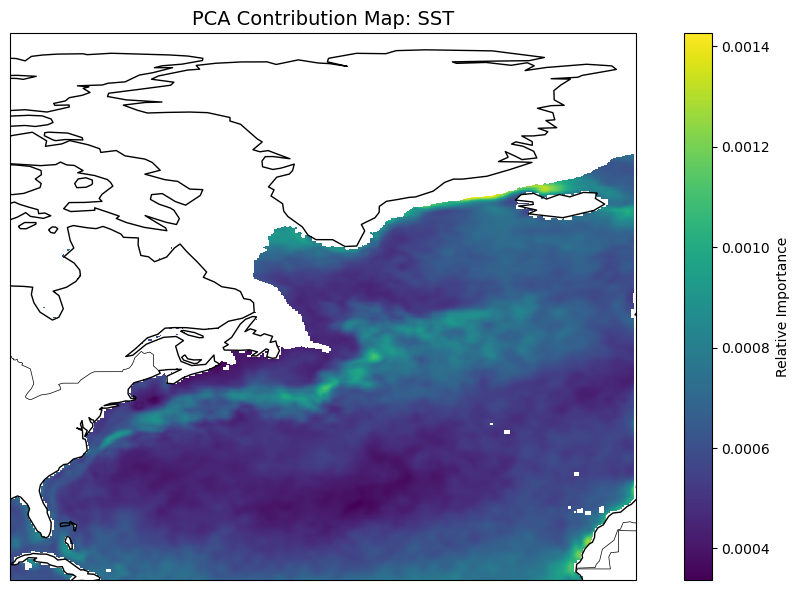

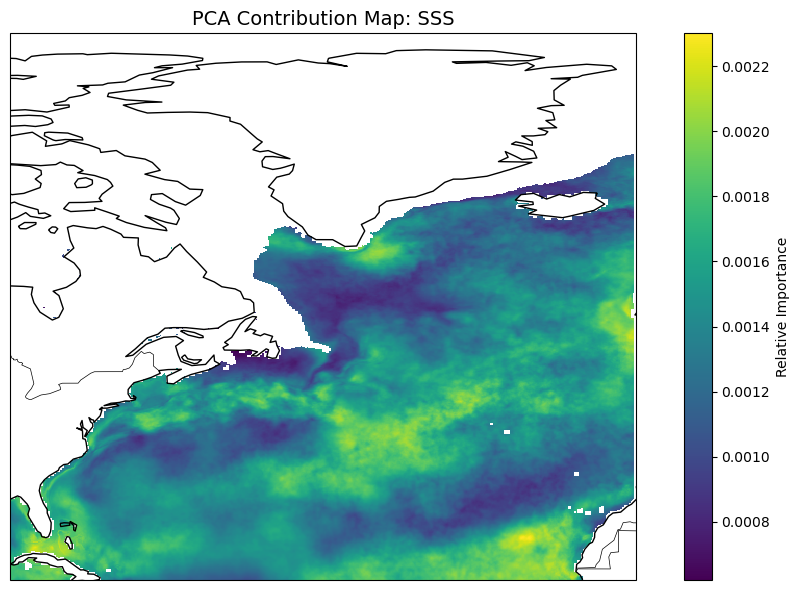

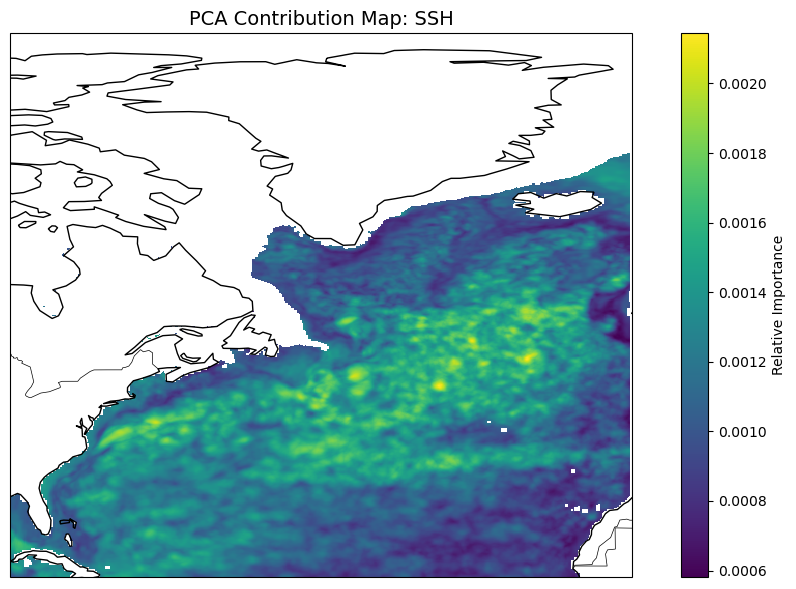

In [11]:

# ------------------------- Ensure Figures Directory Exists -------------------------
fig_dir = "figures"
os.makedirs(fig_dir, exist_ok=True)
print(f"Saving figures to directory: {fig_dir}")

# ------------------------- Load Saved Data -------------------------
data = np.load("amoc_ml_input_output.npz", allow_pickle=True)
contrib_data = np.load("pca_contrib_data.npz")

mean_pca_contrib = contrib_data["mean_pca_contrib"]  # (total_features,)
sst_shape = data["sst_shape"]                        # (525, 601)

# ------------------------- Load lat/lon -------------------------
ds_sst = xr.open_dataset("/mnt/f/AMOC_Tipping_ML/data/ERA5_SST_fine_sst_trimmed_rename.nc", decode_times=False)
lon = ds_sst["lon"].values                           # (601,)
lat = ds_sst["lat"].values                           # (525,)
lon2d, lat2d = np.meshgrid(lon, lat)

sst = ds_sst['sst'].values - 273.15  # convert K to °C

# ------------------------- Load other datasets -------------------------
ds_sss = xr.open_dataset('/mnt/f/AMOC_Tipping_ML/data/cmems_obs-mob_glo_phy-sss_my_multi_fine_sos.nc', decode_times=False)
sss = ds_sss['sos'].values  # (time, lat, lon)

ds_ssh = xr.open_dataset('/mnt/f/AMOC_Tipping_ML/data/cmems_obs-sl_glo_phy-ssh_my_allsat-l4_fine_sla_trimmed.nc', decode_times=False)
ssh = ds_ssh['sla'].values  # (time, lat, lon)

# ------------------------- Rebuild final PCA valid mask -------------------------
valid_mask_combined = np.load("valid_mask_combined.npy")  # shape: (nlat*nlon,)

n_time, nlat, nlon = sst.shape

# Flatten spatial dimensions
sst_flat = sst.reshape(n_time, -1)
sss_flat = sss.reshape(n_time, -1)
ssh_flat = ssh.reshape(n_time, -1)

# Apply time=0 mask
sst_masked = sst_flat[:, valid_mask_combined]
sss_masked = sss_flat[:, valid_mask_combined]
ssh_masked = ssh_flat[:, valid_mask_combined]

# Filter out any grid cell with NaNs over time for all variables
valid_grid_mask = (~np.isnan(sst_masked).any(axis=0)) & \
                  (~np.isnan(sss_masked).any(axis=0)) & \
                  (~np.isnan(ssh_masked).any(axis=0))

# Build final mask over original flattened grid
final_valid_mask = np.zeros(nlat * nlon, dtype=bool)
final_valid_mask[np.where(valid_mask_combined)[0][valid_grid_mask]] = True

print(f"Initial valid points at time=0: {valid_mask_combined.sum()}")
print(f"Valid points after temporal filtering: {final_valid_mask.sum()}")
print(f"PCA contributions length: {mean_pca_contrib.shape[0]}")

# Validate PCA contributions length matches expected size (3 spatial blocks + runoff)
expected_pca_length = final_valid_mask.sum() * 3 + 4  # SST + SSS + SSH + runoff
assert mean_pca_contrib.shape[0] == expected_pca_length, \
    "PCA contributions length does not match expected total features!"

valid_indices = np.where(final_valid_mask)[0]

# ------------------------- Define Feature Blocks -------------------------
block_sizes = [
    final_valid_mask.sum(),  # SST
    final_valid_mask.sum(),  # SSS
    final_valid_mask.sum(),  # SSH
    4                       # runoff (non-spatial)
]
block_names = ["sst", "sss", "ssh", "runoff"]
block_starts = np.cumsum([0] + block_sizes[:-1])

# ------------------------- Process and Plot -------------------------
for name, start, size in zip(block_names, block_starts, block_sizes):
    print(f"Processing block: {name.upper()}")

    if name == "runoff":
        print("Skipping runoff (non-spatial).")
        continue

    contrib = mean_pca_contrib[start:start + size]

    contrib_map_flat = np.full(np.prod(sst_shape), np.nan)
    contrib_map_flat[valid_indices] = contrib
    contrib_map = contrib_map_flat.reshape(sst_shape)

    fig = plt.figure(figsize=(10, 6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    im = ax.pcolormesh(lon2d, lat2d, contrib_map,
                       transform=ccrs.PlateCarree(),
                       cmap="viridis")

    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.set_title(f"PCA Contribution Map: {name.upper()}", fontsize=14)
    plt.colorbar(im, ax=ax, orientation='vertical', label="Relative Importance")
    plt.tight_layout()

    fig_path = os.path.join(fig_dir, f"pca_contrib_{name.lower()}.png")
    plt.savefig(fig_path, dpi=300)
    print(f"Saved: {fig_path}")

# plt.show()  # Optional: comment/uncomment for interactive display
